In [116]:
import os
import pandas as pd 
import math
import numpy as np 
import matplotlib.pyplot as plt
import random as r 
import preputil as util 
from matplotlib import colors
import progressbar
pd.options.mode.chained_assignment = None  # default='warn'

In [6]:
combined_file = "/nBodyData/combinedAll_3_1.csv"
df = pd.read_csv(combined_file)

In [118]:


df["delta_solns"] = np.sqrt(((df['x1tEnd'] - df['x1tEnd_j'])**2) + ((df['x2tEnd'] - df['x2tEnd_j'])**2) + ((df['x3tEnd'] - df['x3tEnd_j'])**2) 
                            +((df['y1tEnd'] - df['y1tEnd_j'])**2) +((df['y2tEnd'] - df['y2tEnd_j'])**2) + ((df['y3tEnd'] - df['y3tEnd_j'])**2))

amse_x1 = []
amse_x2 = []
amse_x3 = []
amse_y1 = []
amse_y2 = []
amse_y3 = []

times = np.linspace(0, 10, num=2561)
for i,t in progressbar.progressbar(enumerate(times)):
    df_t = df.loc[df['tEnd'] == times[i]]
    for j in range(1,4):
        df_t["mse_x{0}".format(j)] = np.sqrt((df_t['x{0}tEnd'.format(j)] - df_t['x{0}tEnd_j'.format(j)])**2)
        df_t["mse_y{0}".format(j)] = np.sqrt((df_t['y{0}tEnd'.format(j)] - df_t['y{0}tEnd_j'.format(j)])**2)
    
    amse_x1.append(df_t["mse_x1"].mean(axis=0))
    amse_x2.append(df_t["mse_x2"].mean(axis=0))
    amse_x3.append(df_t["mse_x3"].mean(axis=0))
    amse_y1.append(df_t["mse_y1"].mean(axis=0))
    amse_y2.append(df_t["mse_y2"].mean(axis=0))
    amse_y3.append(df_t["mse_y3"].mean(axis=0))

| | #                                              | 2560 Elapsed Time: 0:00:19


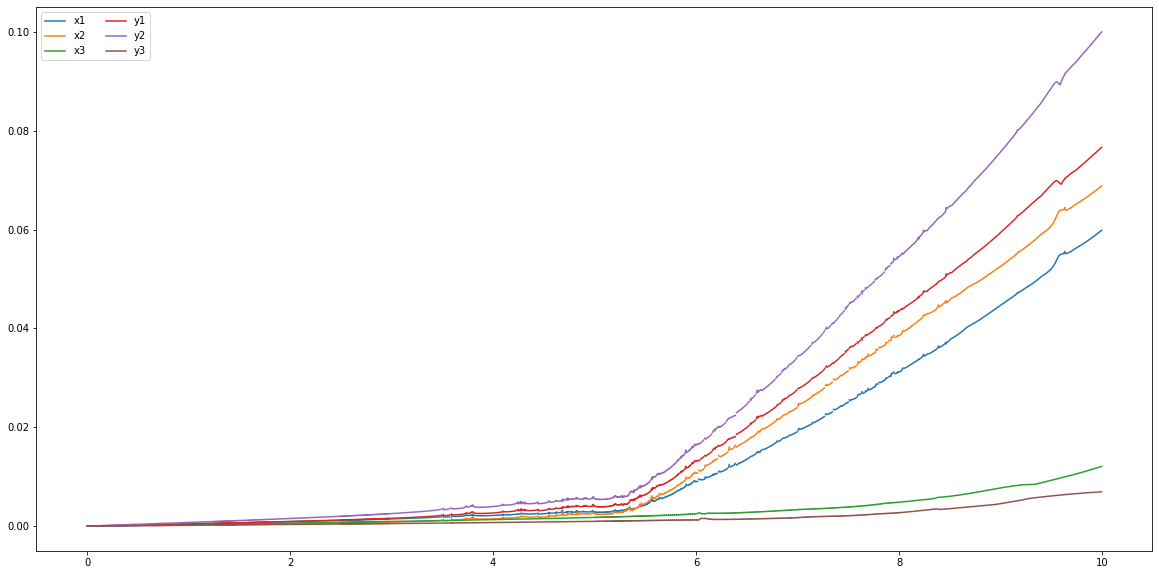

In [123]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (20, 10)
ax.plot(times, amse_x1, label="x1")
ax.plot(times, amse_x2, label="x2")
ax.plot(times, amse_x3, label="x3")
ax.plot(times, amse_y1, label="y1")
ax.plot(times, amse_y2, label="y2")
ax.plot(times, amse_y3, label="y3")
ax.legend(loc='best', ncol=2, fancybox=True)

# ax.plot(df['tEnd'], df['delta_solns'])
# ax.set_yscale('log')
# # ax.set_xscale('log')
# ax.set_ylim(10e-5, 20)